In [77]:
# Chargement des biblios

import pandas as pd

import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl

import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point

import datetime as dt

import seaborn as sns

import tilemapbase



In [310]:
# Définition des fonts qui seront utilisées pour les plots

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 18}

font_ticks = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 14}


# Definition d'un gradient de couleurs qui sera utilisé dans la suite pour certains plots

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c2='black' #blue
c1='lime' #green


In [ ]:


## extract_geo permet de moyenner les données d'un csv complet sur une plage temporelle comprise entre start_date et end_date
## Si delta n'est pas nul, alors la fonction retournera une liste de dataframes avec des intervalles de temps
## compris entre start_date +i*delta et start_date+(i+1)*delta

def extract_geo(df, start_date, end_date, delta=False):
    
    if not(delta):
         
        # on fait un groupby par station par le biais la colonne 'name', pour des dates comprises entre start_date et end_date
        # Aggregateur mean, du coup on ne traite que les colonnes sur les quelles ca a du sens du faire une moyenne
        df_geo = df.loc[(df['ping_time']<end_date) & (df['ping_time']>=start_date) , ['stationcode', 'ebike', 'mechanical',
               'numbikesavailable', 'numdocksavailable', 'capacity', 'is_renting',
               'is_installed', 'is_returning','name']].groupby('name').mean()
        
        df_geo = df_geo.reset_index()
        
        # Groupby avec comme aggrégateur first, pour les colonnes sur les quelles on ne peut pas faire de moyenne
        liste_station = df[['name', 'nom_arrondissement_communes', \
                        'longitude', 'latitude']].groupby('name').first().reset_index()
        
        
        # On fusionne les deux groupby
        df_geo = liste_station.merge(df_geo, how='inner', left_on = 'name', right_on = 'name')
        df_geo = df_geo.dropna()
        
        res = df_geo
        
    else:
        # Meme principe que précédement, avec prise en compte du delta
                                     
        res=[]
        while (start_date < end_date):
                    
            df_geo = df.loc[(df['ping_time']<start_date+delta) & (df['ping_time']>=start_date) , ['stationcode', 'ebike', 'mechanical',
                   'numbikesavailable', 'numdocksavailable', 'capacity', 'is_renting',
                   'is_installed', 'is_returning', 'name']].groupby('name').mean()
            
            df_geo = df_geo.reset_index()
            
            liste_station = df[['name','nom_arrondissement_communes', \
                            'longitude', 'latitude']].groupby('name').first().reset_index()
            
            df_geo = liste_station.merge(df_geo, how='inner', left_on = 'name', right_on = 'name')
            df_geo = df_geo.dropna()
            
            res.append(df_geo)
            
            start_date += delta
    
    return res

In [227]:



## Fonction permettant d'agglomerer les données ponctuelles des station sur les communes auquelles elles appartiennent.
## agreg : aggregateur utilisé, par defaut mean
## diff : si égale a True, df doit être une dataframe issue de la fonction diff_df

def agglo_station_sur_communes(df, agreg='mean', diff=False):
    
    # Conversion du df au format gdf en utilisant lat et long pour definir des points
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

    # Chargement du shp qui contient les infos sur les communes
    gdf_idf = gpd.read_file('Data\\Data_complementaires\\Data_idf\\data_idf.shp')

    # sjoin entre les deux gdf du dessus, puis on ne garde que les colonnes qui nous interesse
    # sjoin va regarder a quelle commune appartient les points
    # Il va nous rendre un gdf des stations, avec comme infos supplementaires la commune ou se trouve la station 
    sj = gpd.sjoin(gdf, gdf_idf, how="inner", predicate="within")
    
    if diff:
        sj = sj[['diff', 'pop','com', 'geometry']]
    else :
        sj = sj[['numbikesavailable','numdocksavailable','capacity','ebike','mechanical','pop','com', 'geometry']]
    
    # on fait ensuite un groupby sur les communes pour agglomer
    sj = sj.dissolve('com', aggfunc=agreg)
    # on retire geometry qui contient les positions des stations car ca ne nous itneresse plus
    sj  = sj.drop(columns=['geometry', 'pop'])
    
    # On joint avec les data sur les communes pour avoir les infos sur la population (pop) et et frontieres (geometry)
    # jointure a droite pour avoir l'info sur les communes qui n'ont pas de stations. 
    gdf_res = gpd.GeoDataFrame(
        sj.merge(gdf_idf, how='right', left_on='com', right_on='com'), geometry='geometry', crs="EPSG:4326")

    # Pour certaines communes les populations sont égales à 0. je remplace par des NaN pour car se sont des infos manquantes. 
    gdf_res['pop'] = gdf_res['pop'].replace(0, np.nan)
    
    if diff:
        # diff_area contient la difference divisée par la surface de la commune
        gdf_res['diff_area'] =  gdf_res['diff']  /  gdf_res.to_crs(2154).area
        
        # diff_pop contien tla différence divisée par la population de la commune
        gdf_res.loc[~gdf_res['pop'].isna() , 'diff_pop'] =  \
            gdf_res.loc[~gdf_res['pop'].isna() , 'diff']  /  gdf_res.loc[~gdf_res['pop'].isna() , 'pop']

    else:
        # disp_area contient la disponibilité divisée par la surface de la commune
        gdf_res['disp_area'] =  gdf_res['numbikesavailable']  /  gdf_res.to_crs(2154).area
        # cap_area contient la capacité divisée par la surface de la commune
        gdf_res['cap_area'] =  gdf_res['capacity']  /  gdf_res.to_crs(2154).area
        
        gdf_res.loc[~gdf_res['pop'].isna() , 'disp_pop'] =  \
            gdf_res.loc[~gdf_res['pop'].isna() , 'numbikesavailable']  /  gdf_res.loc[~gdf_res['pop'].isna() , 'pop']
        gdf_res.loc[~gdf_res['pop'].isna() , 'cap_pop'] =  \
            gdf_res.loc[~gdf_res['pop'].isna() , 'capacity']  /  gdf_res.loc[~gdf_res['pop'].isna() , 'pop']


    return gdf_res



    



In [ ]:

# calcul la différence entre deux dataframe issus de extract_geo
# ATTENTION: on fait df2 - df1
# Permet de voir les varations géographiques de disponiblités entre deux dates

def diff_df(df1, df2):
     
    # on merge df1 et df2
    merge = df1[['numbikesavailable', 'name', 'latitude', 'longitude']]\
    .merge(df2[['numbikesavailable', 'name', 'latitude', 'longitude']], \
           how='outer', left_on = 'name', right_on = 'name')
    
    # remplacement des NaN par 0 
    # Il y a des NaN quand par exemple les stations ne sont pas les mêmes entre df1 et df2. 
    # Si par exemple df1 contient une station S qui n'est pas dans df2, alors merge['numbikesavailable_y'] = NaN pour la ligne
    # correspondant a la station S
    merge[['numbikesavailable_x','numbikesavailable_y']] = merge[['numbikesavailable_x','numbikesavailable_y']].replace(np.nan, 0)
    # Calcul de la différence de disponiblité
    merge['diff'] = merge['numbikesavailable_x'] - merge['numbikesavailable_y']
    # On dégage les colonnes qui ne servent plus a rien
    merge = merge.drop(columns=['numbikesavailable_x','numbikesavailable_y'])
    
    # On fusionne les coordonnées des stations en prenant en compte le fait que les stations de df1 ne sont pas
    # necessairement les mêmes que celle de df2
    mask_x = (merge['latitude_x'].isna())
    mask_y = (merge['latitude_y'].isna())
    merge.loc[mask_x, 'latitude_x']  = merge.loc[mask_x, 'latitude_y']
    merge.loc[mask_x, 'longitude_x'] = merge.loc[mask_x, 'longitude_y']
    merge = merge.drop(columns= ['latitude_y', 'longitude_y'])
    
    # date_station :
    # egal a 1 si la station n'est pas présente dans df2 mais dans df1
    merge.loc[mask_y, 'date_station'] = 1
    # egal a -1 si la station n'est pas présente dans df1 mais dans df2
    merge.loc[mask_x, 'date_station'] = -1
    # egal a 0 si la station est présente dans df1 et df2
    merge.loc[~mask_x & ~mask_y, 'date_station'] = 0
    
    # date_station nous donne donc des infos sur les stations créées et suprimées entre df1 et df2
    
    # On renomme certaines colonnes pour faire plus propre
    merge = merge.rename(columns={'latitude_x':'latitude', 'longitude_x':'longitude'})
    
    return merge 


In [334]:
# Fonction calculant la carte des différence par heure et par eloignement du centre de l'endroit donné

# Prend en argument 

# L_df une liste de dataframe issues de extract_geo (avec un delta non null)

# delta_H : l'écart entre les dates pour calculer la différence, par défaut 1. 
# Exemple: soit L_df une liste de dataframe séparées les unes des autres par 1h. 
# Si delta_h=1, alors nous calculerons la différence heure par heure
# Si delta_h=24, alors nous calculerons la différence entre le jour j et le jour j+1, heure par heure. 

# R_max le rayon max ou l'on regarde les stations
# delta_R la variation du rayon. 
# Exemple R_max=1 et delta_R=0.5
# la fonction calculera la différence pour les stations dans un rayon de 0.5km du lieu, puis dans un rayon compris
# entre 0.5km et 1km du lieu, etc... 

# lieu : l'endroit autour du quelle on regarde les stations, par défaut le centre de Paris



 

def map_difference(L_df, R_max, delta_R, lieu='paris_centre', delta_time=1):       

    L_R = np.arange(0,R_max,delta_R)
    
    dispo=np.zeros((int(len(L_df))-delta_time, len(L_R)))
    
    i=0;j=0
    
    while j < len(L_R):
        
        while i < int(len(L_df)-delta_time):
            
            # Ccalcul de la différence entre l'heure i et l'heure i+1
            diff = diff_df(L_df[i], L_df[i+delta_time])
            gdf_diff = gpd.GeoDataFrame(
                diff, geometry=gpd.points_from_xy(diff.longitude, diff.latitude), crs="EPSG:4326")
            
            # On pose une condition pour ne garder que les station dont la distance est entre L_R[i] et L_R[i+1]
            # du centre de Paris :
            dist_centre = gdf_diff.to_crs(2154).distance(gdf_sites.loc[gdf_sites['name']==lieu].to_crs(2154)['geometry'].iloc[0]).div(10**3)
            mask_r = (dist_centre >= L_R[j] ) & ( dist_centre < L_R[j] + delta_R )
    
            # Puis on stock la moyenne de leurs différences disponibilité dans dispo[i,j]
            # dispo[i,j] : diff de dispo à l'heure i pour les stations dans un rayon de L_R[j] du centre de Paris
            dispo[i,j] = gdf_diff.loc[mask_r, 'diff'].mean()
    
            i+=1
    
        i=0; j+=1
    
    
    return dispo
    

In [258]:
   
# map_stations affiche sur un fond de carte OSM les stations a R km autours du lieu donné. 
# delta_R permet de faire un gradiant de couleur, avec des couleurs plus claires au proche du lieu et plus
# sombres lorsqu'on s'en éloigne. delta_R doit etre inferieur a R.. 
def map_stations(df, R, lieu, delta_R=R,  titre=''):


    gdf = gpd.GeoDataFrame(
            df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
    
    # Conversion au bon crs pour l'utilisation du fond de map
    gdf_2 = gdf.to_crs("EPSG:3857")
    gdf_idf_2 = gdf_idf.to_crs("EPSG:3857")
    
    
    # d : distance des stations par rapport a Bercy
    d = gdf.to_crs(2154).distance(gdf_sites.loc[gdf_sites['name']==lieu].to_crs(2154)['geometry'].iloc[0]).div(10**3)
    mask_R = (d < R)
    
    # Mise en place du fond de carte :
    tilemapbase.start_logging()
    tilemapbase.init(create=True)
    extent = tilemapbase.extent_from_frame(gdf.to_crs("EPSG:3857").loc[mask_R], buffer = 25)
    plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
    
    
    fig, ax = plt.subplots(figsize=(8,6))
    # Affichage du fond de carte
    plotter.plot(ax)
    
    gdf_sites.to_crs("EPSG:3857").loc[gdf_sites['name']==lieu].plot(ax=ax,color='r', alpha = 0.6, markersize=40, edgecolor='black')
    # On fait varier la couleur des plots des stations en fonction de la distance par rapport au lieu, ici Bercy
    for r in np.arange(0, R, delta_R):
            mask = ((d < r+delta_R) & (d >= r))
            gdf_2.to_crs("EPSG:3857").loc[mask].plot(ax=ax, alpha = 0.6, color=colorFader(c1,c2,r/R), edgecolor="black", markersize=20)
    
    ax.set_yticks([], [])
    ax.set_xticks([], [])
    ax.set_title(titre, **font)
    
    plt.show()   

In [161]:

# Chargemenet des ifnos sur les communes
gdf_idf = gpd.read_file('Data\\Data_complementaires\\Data_idf\\data_idf.shp')


# Sauvegarde dans un gdf de position de sites remarquables 

paris_centre = [48.8534100, 2.3488000, 'paris_centre']
bercy = [48.838703, 2.377946, 'bercy']
sdf = [48.921329648, 2.355998576, 'SDF' ]
gdn = [48.880931, 2.355323, 'GDN']




df_sites = pd.DataFrame(np.array([paris_centre, bercy, sdf, gdn]),  columns=['lat', 'long', 'name'])

gdf_sites = gpd.GeoDataFrame(
        df_sites, geometry=gpd.points_from_xy(df_sites.long, df_sites.lat), crs="EPSG:4326")


In [6]:
gdf_sites

,lat,long,name,geometry
0,48.85341,2.3488,paris_centre,POINT (2.34880 48.85341)
1,48.838703,2.377946,bercy,POINT (2.37795 48.83870)
2,48.8809,2.3553,SDF,POINT (2.35530 48.88090)
3,48.880931,2.355323,GDN,POINT (2.35532 48.88093)


# Repartition du réseau à l'echelle communale

In [7]:
## Chargement du csv du mois de mai 2O23
df_may23_tot = pd.read_csv('Data\\Data_velib\\Data_traitées\\Velib_MAY_2023.csv', parse_dates = ['duedate', 'ping_time'])



In [8]:
# Extraction data moyennées sur le mois de mai grace a extract_geo
start_date = dt.datetime(2023, 5, 1)
end_date = dt.datetime(2023, 5, 1) + pd.DateOffset(months=1)
df_may = extract_geo(df_may23_tot, start_date, end_date)


In [9]:
# On agglomere avec une somme les données sur les communes, 
gdf_may_sum  = agglo_station_sur_communes(df_may, agreg='sum')

## Repartition de la disponiblité

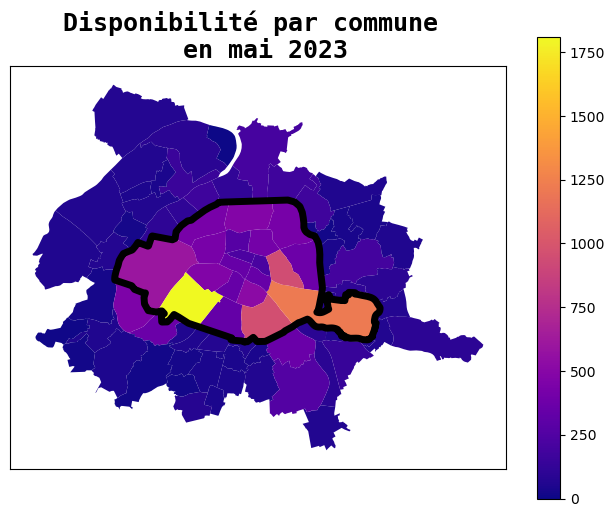

In [311]:
fig, ax = plt.subplots(figsize = (8,6))

ax.set_title('Disponibilité par commune \n en mai 2023', **font)
ax.set_yticks([], [])
ax.set_xticks([], [])

a = gdf_may_sum.plot(
    ax=ax,
    column='numbikesavailable', 
    legend=True, 
    cmap='plasma',
    legend_kwds={
        'ticks' : None,
    }
    )

mask = (gdf_idf["dep"]=='75')
gdf_idf[mask].dissolve("dep").boundary.plot( ax=ax,color='black', linewidth=5 )

plt.show()
#plt.savefig("resultats_viz\\geo\\repartition_disponibilite.png")

## Repartition de la disponiblité divisé par la surface de la commune

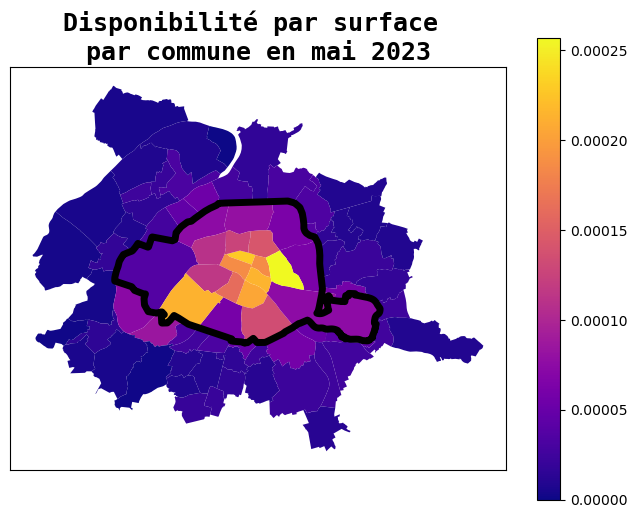

In [312]:
fig, ax = plt.subplots(figsize = (8,6))

ax.set_title('Disponibilité par surface \npar commune en mai 2023', **font)
ax.set_yticks([], [])
ax.set_xticks([], [])

a = gdf_may_sum.plot(
    ax=ax,
    column='disp_area', 
    legend=True, 
    cmap='plasma',
    legend_kwds={
        'ticks' : None,
    }
    )

mask = (gdf_idf["dep"]=='75')
gdf_idf[mask].dissolve("dep").boundary.plot( ax=ax,color='black', linewidth=5 )

plt.show()

#plt.savefig("resultats_viz\\geo\\repartition_disponibilite.png")

## Repartition de la capacité 

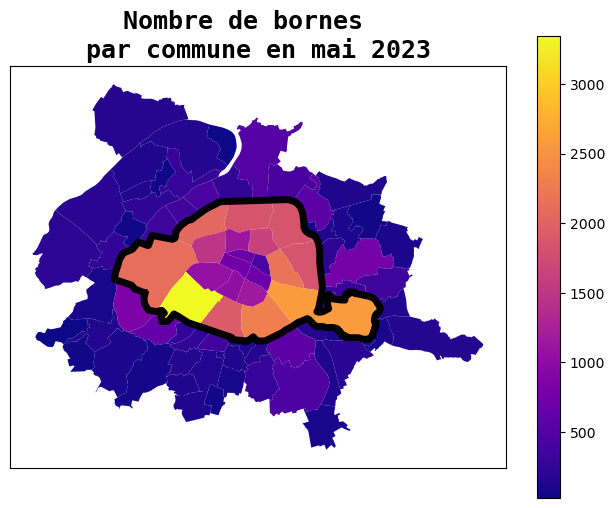

In [313]:

fig, ax = plt.subplots(figsize = (8,6))


ax.set_title('Nombre de bornes  \npar commune en mai 2023', **font)
ax.set_yticks([], [])
ax.set_xticks([], [])

a = gdf_may_sum.plot(
    ax=ax,
    column='capacity', 
    legend=True, 
    cmap='plasma',
    legend_kwds={
        'ticks' : None,
    }

    )

mask = (gdf_idf["dep"]=='75')
gdf_idf[mask].dissolve("dep").boundary.plot( ax=ax,color='black', linewidth=5 )

plt.show()
#plt.savefig("resultats_viz\\geo\\repartition_capacite_area.png")

## Repartition de la capacité divisée par la surface

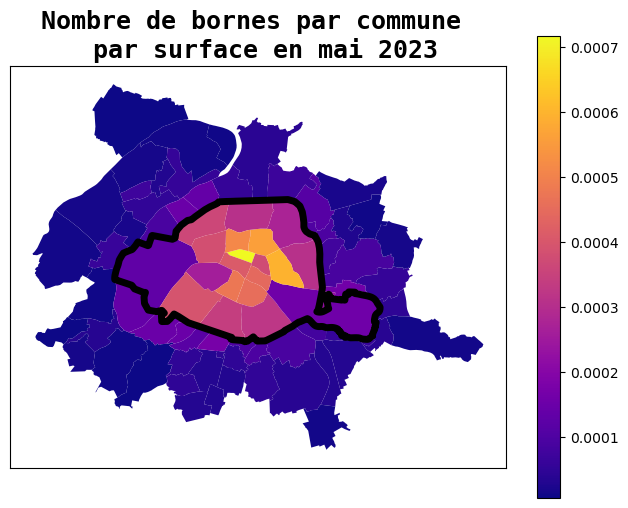

In [314]:
fig, ax = plt.subplots(figsize = (8,6))

ax.set_title('Nombre de bornes par commune \n par surface en mai 2023', **font)
ax.set_yticks([], [])
ax.set_xticks([], [])

a = gdf_may_sum.plot(
    ax=ax,
    column='cap_area', 
    legend=True, 
    cmap='plasma',
    legend_kwds={
        'ticks' : None,
    }
    )

mask = (gdf_idf["dep"]=='75')
gdf_idf[mask].dissolve("dep").boundary.plot( ax=ax,color='black', linewidth=5 )

plt.show()
# plt.savefig("resultats_viz\\geo\\repartition_capacite.png")

# Etude journaliere (12 janvier 2023 comme dans la partie d'Ahmed)

In [316]:
# Chargement du mois de janvier 2023
df_jan23_tot = pd.read_csv('Data\\Data_velib\\Data_traitées\\Velib_JAN_2023.csv', parse_dates = ['duedate', 'ping_time'])

In [317]:
# On ne garde que la journée du 12
start_date = dt.datetime(2023, 1, 12)
end_date = dt.datetime(2023, 1, 12) + pd.DateOffset(days=1)
# On prend un delta de 1 pour analyser la journée heure par heure. 
delta = pd.DateOffset(hours=1)
        
df_12_janvier = extract_geo(df_jan23_tot, start_date, end_date, delta)


### Etude de la différence entre 5h (stations pleines) et 9h (stations vides) 

In [338]:

# df_12_janvier[i] : moyenne entre i h et (i+1) h
# On calcul la différence entre 9h et 4h
diff = diff_df(df_12_janvier[3], df_12_janvier[8])

# diff > 0 : la commune gagne , les velos ynarrivent
# diff < 0 : l'inverse

# On agglomere le resultat de la différence sur les communes
gdf_diff  = agglo_station_sur_communes(diff, agreg='mean', diff=True)


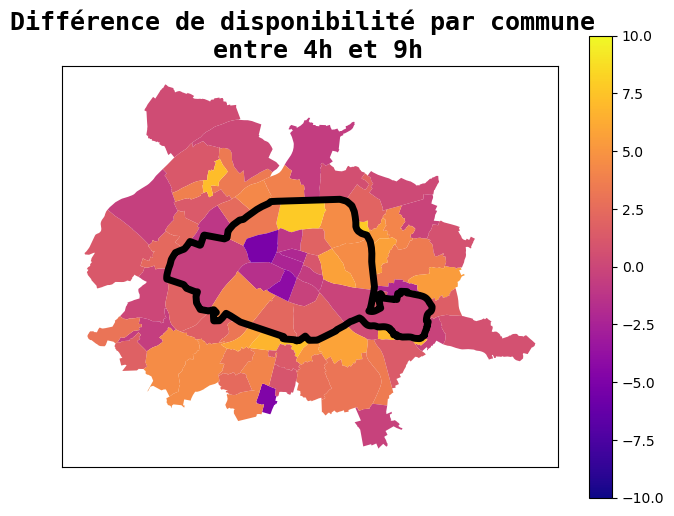

In [341]:

fig, ax = plt.subplots(figsize = (8,6))

mask = (gdf_idf["dep"]=='75')
gdf_idf[mask].dissolve("dep").boundary.plot( ax=ax,color='black', linewidth=5 )

ax.set_title('Différence de disponibilité par commune \n entre 4h et 9h', **font)
ax.set_yticks([], [])
ax.set_xticks([], [])

gdf_diff.plot(
    ax=ax,
    column='diff', 
    cmap='plasma',
    legend=True, 
    vmin=-10,
    vmax= 10
    )

plt.show()

### etude de la différence entre 9h (stations pleines) et 12h (stations vides)  (flux global positif)

In [342]:
diff = diff_df(df_12_janvier[8], df_12_janvier[11])
gdf_diff  = agglo_station_sur_communes(diff, agreg='mean', diff=True)


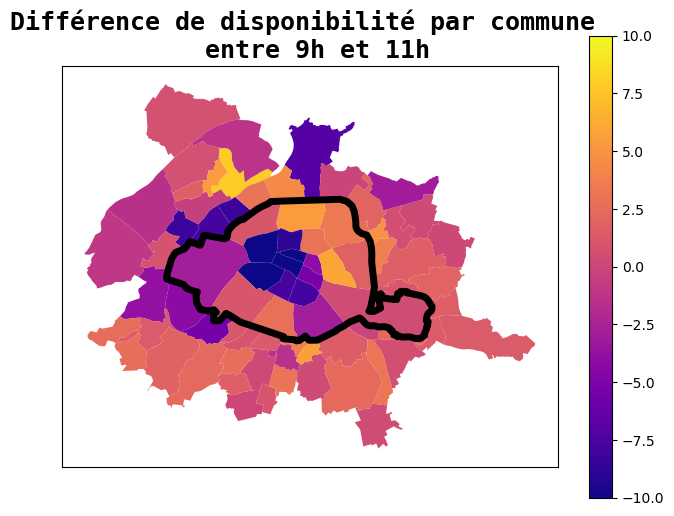

In [343]:

fig, ax = plt.subplots(figsize = (8,6))

mask = (gdf_idf["dep"]=='75')
gdf_idf[mask].dissolve("dep").boundary.plot( ax=ax,color='black', linewidth=5 )

ax.set_title('Différence de disponibilité par commune \n entre 9h et 11h', **font)
ax.set_yticks([], [])
ax.set_xticks([], [])

gdf_diff.plot(
    ax=ax,
    column='diff', 
    legend=True, 
    cmap='plasma',
    vmin=-10,
    vmax= 10
    )

plt.show()

In [344]:
diff = diff_df(df_12_janvier[14], df_12_janvier[18])
gdf_diff  = agglo_station_sur_communes(diff, agreg='mean', diff=True)

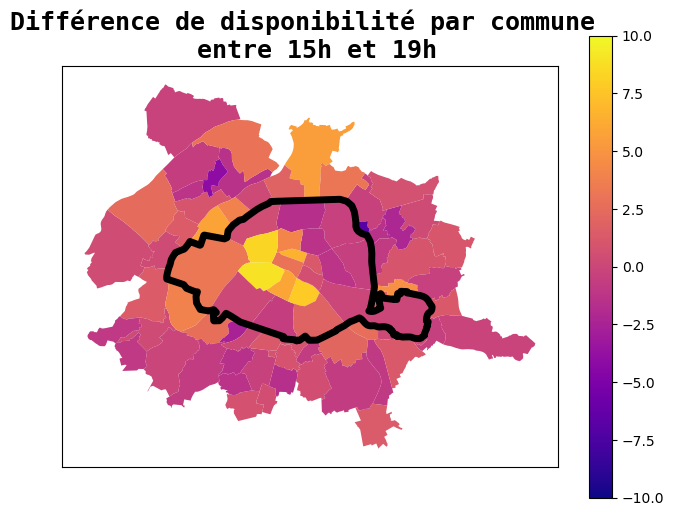

In [345]:
fig, ax = plt.subplots(figsize = (8,6))

ax.set_title('Différence de disponibilité par commune \n entre 15h et 19h', **font)
ax.set_yticks([], [])
ax.set_xticks([], [])

mask = (gdf_idf["dep"]=='75')
gdf_idf[mask].dissolve("dep").boundary.plot( ax=ax,color='black', linewidth=5 )

gdf_diff.plot(
    ax=ax,
    column='diff', 
    cmap='plasma',
    vmin=-10,
    vmax= 10,
    legend=True
    
    )

plt.show()


In [346]:
diff = diff_df(df_12_janvier[18], df_12_janvier[23])
gdf_diff  = agglo_station_sur_communes(diff, agreg='mean', diff=True)


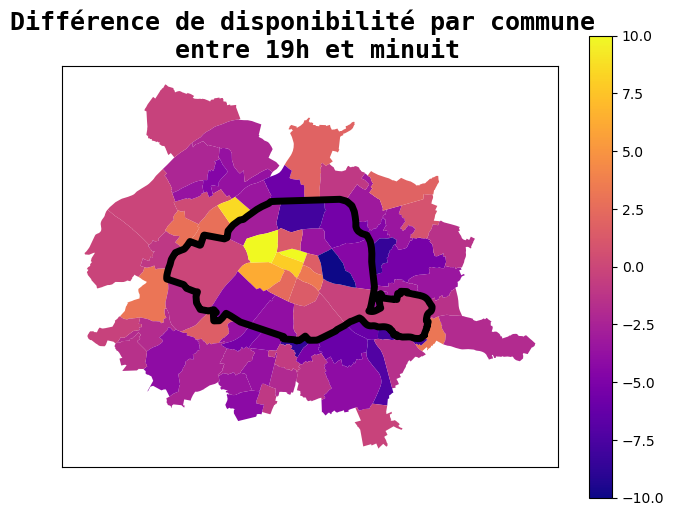

In [347]:

fig, ax = plt.subplots(figsize = (8,6))

ax.set_title('Différence de disponibilité par commune \n entre 19h et minuit', **font)
ax.set_yticks([], [])
ax.set_xticks([], [])

mask = (gdf_idf["dep"]=='75')
gdf_idf[mask].dissolve("dep").boundary.plot( ax=ax,color='black', linewidth=5 )

gdf_diff.plot(
    ax=ax,
    column='diff', 
    legend=True, 
    cmap='plasma',
    vmin=-10,
    vmax= 10
    )


plt.show()

# Synthése de la journée type par le biais d'une carte des vitesses

In [335]:
# Calcul de la map des variations de la disponbilité par heure et par eloignement du centre de Paris
map_dispo = map_difference(df_12_janvier, 5, 0.2, lieu='paris_centre')

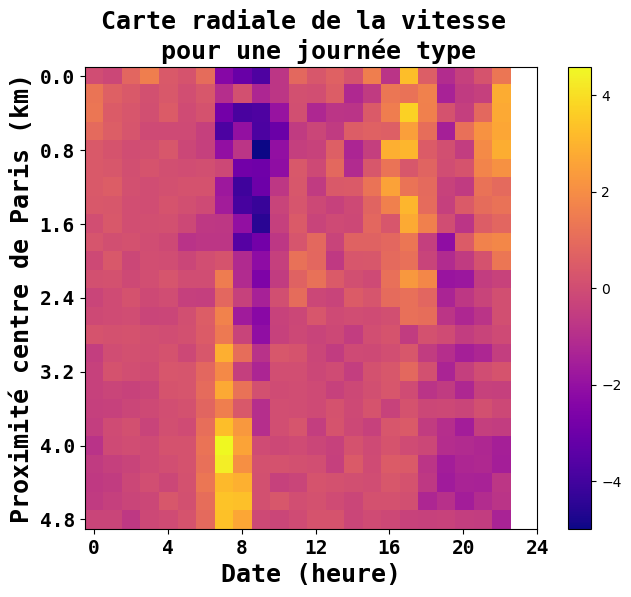

In [336]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(
    map_dispo.transpose(), 
    vmin= map_dispo.transpose().min(), 
    vmax= map_dispo.transpose().max(),
    cmap='plasma'
    )

cbar = ax.figure.colorbar(im)
plt.title('Carte radiale de la vitesse \n pour une journée type',**font)

labels_x = np.arange(0,28,4)
plt.xticks(np.arange(0,28,4), labels_x,**font_ticks) 

labels_y = np.arange(0,25*0.2,4*0.2)
plt.yticks(np.arange(0,25,4), labels_y.round(2), **font_ticks) 

plt.xlabel('Date (heure)' , **font) 
plt.ylabel('Proximité centre de Paris (km)', **font) 


plt.show()

# En jaune : gain de vélib
# En Bleu : perte de velib
# -> Cette carte est une manière compacte de voir les transferts de vélo au cours d'une journée autour d'un endroit particulier, ici le centre de Paris

# Un jour de concert : Arctic Monkeys, Bercy le 9 mai 2023

## On va faire la différence heure par heure avec le 8 mai pour voir
## les differences entre avec concert et sans concert


In [70]:
# ATTENTION CEST LONG

start_date = dt.datetime(2023, 5, 8) + pd.DateOffset(hours=12)
end_date = dt.datetime(2023, 5, 8) + pd.DateOffset(days=2) + pd.DateOffset(hours=12)
delta = pd.DateOffset(minutes=10)
        
df_concert = extract_geo(df_may23_tot, start_date, end_date, delta)

# Visualisation de lemplacement de sstations autour de Bercy 

In [230]:
delta_R= 1; R= 3.1; lieu = 'bercy'

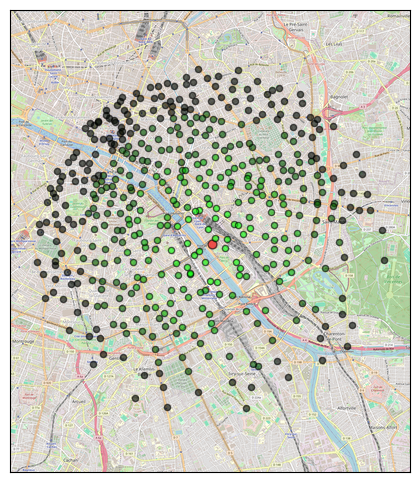

In [266]:
map_stations(df_concert[0], R, lieu , delta_R=delta_R)

# Etude de la différence de disponibilité entre le jour du concert et le jour d'avant

In [299]:
# delta_h = 6*24 : on a un ecart de 10mn, donc 6*10mn=1h, 1h*24 = 1 jour
dispo_concert=map_difference(df_concert, R_max= R, delta_R= delta_R, lieu=lieu, delta_time= 6*24)


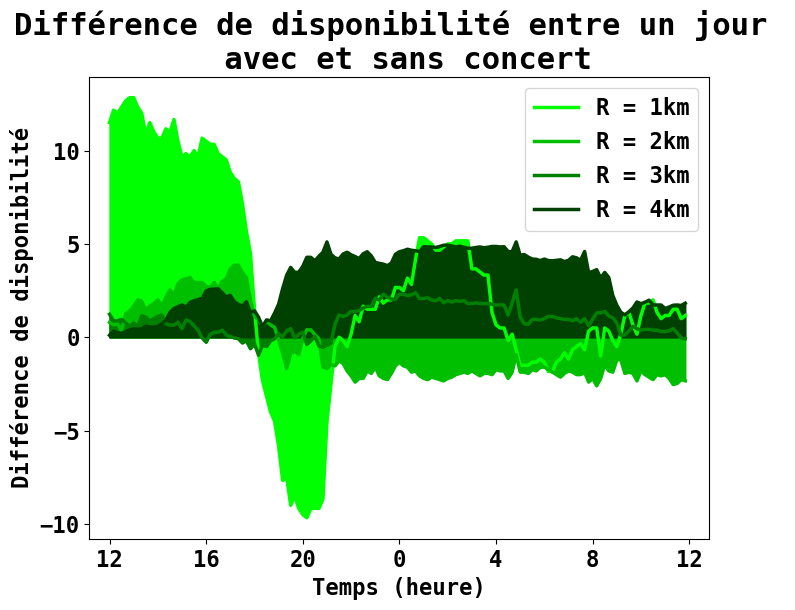

In [300]:
fig, ax = plt.subplots(figsize=(8,6))


n=len(np.arange(0,R,delta_R))

for i in range(0, n, 1):
    ax.plot(dispo_concert[:,i], color=colorFader(c1,c2,i/n), linewidth=2.5, label= 'R = '+str(round(i*delta_R+1,2))+'km')
    ax.fill_between(np.arange(0, len(dispo_concert[:,i]), 1), dispo_concert[:,i], color = colorFader(c1,c2,i/n))

labels_x = np.remainder(np.arange(0,(6*24+1)/6,4)+12,24)
plt.xticks(np.arange(0,6*24+1,1*6*4) , labels_x.astype(int),**font_ticks)
plt.yticks(**font_ticks)
ax.set_xlim(-5,149)

ax.set_xlabel('Temps (heure)', **font_ticks)
ax.set_ylabel('Différence de disponibilité', **font_ticks)
ax.set_title('Différence de disponibilité entre un jour \n avec et sans concert', **font)


ax.legend(prop=font_ticks)

plt.show()

## Différence de dispo  > 0 : gain de disponibilité le jour du match
## Différence de dispo  < 0 : on perd de la disponibilité 

## Proche de Bercy, on observe donc un gain de dispo avant le concert (avant 18h)
## Ca correspond aux personnes qui viennent au concert en vélo et qui deposent donc des velibs dans les stations aux alentours
## Passé 18h, la tendance s'inverse. Les stations se vident progressivement, au depart par des gens n'aillant rien a voir avec le concert puis par les spectateurs qui quittent la salle une fois l'evement fini. 

# Etude du match de rugby France Nouvelle Zelande le 8 sep 23

In [271]:
df_sep23_tot = pd.read_csv('Data\\Data_velib\\Data_traitées\\Velib_SEP_2023.csv', parse_dates = ['duedate', 'ping_time'])


In [304]:
start_date = dt.datetime(2023, 9, 7) + pd.DateOffset(hours=12)
end_date = dt.datetime(2023, 9, 7) + pd.DateOffset(days=2) + pd.DateOffset(hours=12)
delta = pd.DateOffset(minutes=10)
        
df_match = extract_geo(df_sep23_tot, start_date, end_date, delta)

In [305]:
delta_R= 1; R= 3.1; lieu = 'SDF'

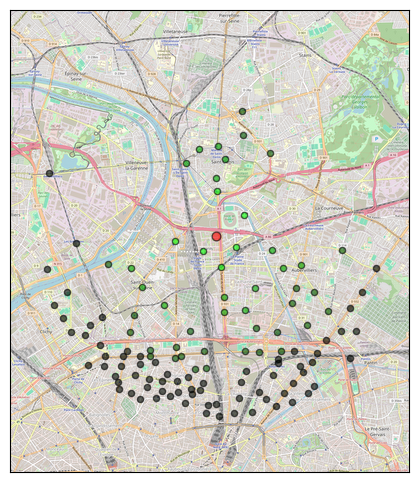

In [306]:
map_stations(df_match[0], R, lieu , delta_R=delta_R)

In [348]:
dispo_match=map_difference(df_match, R_max= R, delta_R= delta_R, lieu=lieu, delta_time= 6*24)


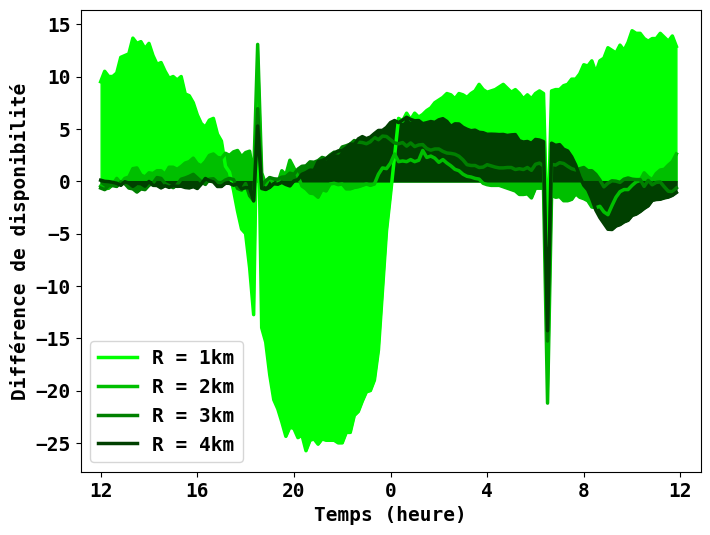

In [349]:
fig, ax = plt.subplots(figsize=(8,6))


n=len(np.arange(0,R,delta_R))

for i in range(0, n, 1):
    ax.plot(dispo_match[:,i], color=colorFader(c1,c2,i/n), linewidth=2.5, label= 'R = '+str(round(i*delta_R+1,2))+'km')
    ax.fill_between(np.arange(0, len(dispo_match[:,i]), 1), dispo_match[:,i], color = colorFader(c1,c2,i/n))

  
labels_x = np.remainder(np.arange(0,(6*24+1)/6,4)+12,24)
plt.xticks(np.arange(0,6*24+1,1*6*4) , labels_x.astype(int),**font_ticks)
plt.yticks(**font_ticks)
ax.set_xlim(-5,149)

ax.set_xlabel('Temps (heure)', **font_ticks)
ax.set_ylabel('Différence de disponibilité', **font_ticks)


ax.legend(prop=font_ticks)

plt.show()

# Comportement similaire a ce qu'on observe un soir de concert a Bercy, mais avec des différences de dispos encore plus prononcées. 
# Normal, les alentours du stade sont moins garnis en station, le systeme est plus facilement mis sous tension